In [369]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [370]:
with open('pg100.txt', 'r') as f:
  data1 = f.read()
with open('pg2600.txt', 'r') as f:
  data2 = f.read()
with open('pg71990.txt', 'r') as f:
  data3 = f.read()

data = data1 + data2 + data3

In [371]:
class Tokenizer:
  def __init__(self,data):
    self.data = data
    self.voc = sorted(list(set(self.data)))
    self.voc_size = len(self.voc)
    self.int2char = {i:c for i,c in enumerate(self.voc)}
    self.char2int = {c:i for i,c in self.int2char.items()}

  def encode(self,char):
    return torch.tensor([self.char2int[c] for c in char],dtype=torch.long)

  def decode(self,char):
    return ''.join([self.int2char[i.item()] for i in char])

tokenizer = Tokenizer(data)

In [372]:
class Loader:
  def __init__(self,HyperParam, val=False) -> None:
    self.tokenizer = Tokenizer(data)
    self.val = val
    self.dataset = self.tokenizer.encode(self.tokenizer.data)
    if self.val:
        self.data = self.dataset[int(0.8*len(self.dataset)):]
    else:
        self.data = self.dataset[:int(0.8*len(self.dataset))]
    self.context_size = HyperParam.context_size
    self.batch_size = HyperParam.batch_size

  def __len__(self):
    return len(self.data)

  def context_size(self):
    return self.context_size

  def voc_size(self):
    return self.tokenizer.voc_size

  def batchify(self):
    index = torch.randint(len(self.data) - self.context_size, (self.batch_size,))
    input = torch.stack([self.data[i:i+self.context_size] for i in index])
    label = torch.stack([self.data[i+1:i+self.context_size+1] for i in index])
    return input,label

In [373]:
class HyperParam:
  context_size = 128
  batch_size = 64
  voc_size = tokenizer.voc_size
  embed_size = 128
  headn = 2
  head_size = embed_size // headn
  n_layers = 3
  updates = 50000
  val_updates = 1000
  lr = 1e-4
  attention_dropout = 0.2
  context_dropout = 0.2
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [374]:
class HeadModule(nn.Module):
  def __init__(self, HyperParam):
    super().__init__()
    self.context_size = HyperParam.context_size
    self.embed_size = HyperParam.embed_size
    self.head_size = HyperParam.head_size
    self.k = nn.Linear(self.embed_size, self.head_size, bias=False)
    self.q = nn.Linear(self.embed_size, self.head_size, bias=False)
    self.v = nn.Linear(self.embed_size, self.head_size, bias=False)
    self.register_buffer('tril', torch.tril(torch.ones(self.context_size,self.context_size)))
    self.dropout = nn.Dropout(HyperParam.attention_dropout)

  def forward(self, x):
    b,t,c = x.shape
    k = self.k(x)
    q = self.q(x)
    w = q@k.transpose(-2,-1) * (c ** 0.5)
    w = w.masked_fill(self.tril[:t,:t]==0,float('-inf'))
    w = F.softmax(w, dim=-1)
    w = self.dropout(w)
    v = self.v(x)
    out = w @ v
    return out

In [375]:
class MultiHead(nn.Module):
  def __init__(self, HyperParam):
    super().__init__()
    self.headn = HyperParam.headn
    self.head_size = HyperParam.head_size
    self.head = nn.ModuleList([HeadModule(HyperParam) for _ in range(self.headn)])
    self.proj = nn.Linear(HyperParam.embed_size, HyperParam.embed_size)
    self.dropout = nn.Dropout(HyperParam.attention_dropout)

  def forward(self,x):
    x = torch.cat([hd(x) for hd in self.head],dim=-1)
    x = self.proj(x)
    x = self.dropout(x)
    return x

In [376]:
class FeedForward(nn.Module):
  def __init__(self, HyperParam):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(HyperParam.embed_size,HyperParam.embed_size * 4),
        nn.ReLU(),
        nn.Linear(HyperParam.embed_size * 4, HyperParam.embed_size),
        nn.Dropout(HyperParam.context_dropout)
    )
  def forward(self,x):
    return self.net(x)

In [377]:
class Transformer(nn.Module):
  def __init__(self, HyperParam):
    super().__init__()
    self.attention = MultiHead(HyperParam)
    self.feed = FeedForward(HyperParam)
    self.layer1 = nn.LayerNorm(HyperParam.embed_size)
    self.layer2 = nn.LayerNorm(HyperParam.embed_size)

  def forward(self,x):
    x = x + self.attention(self.layer1(x))
    x = x + self.feed(self.layer2(x))

    return x

In [378]:
class TransformerModel(nn.Module):
  def __init__(self,HyperParam):
    super().__init__()
    self.embed_size = HyperParam.embed_size
    self.context_size = HyperParam.context_size
    self.tokens = nn.Embedding(HyperParam.voc_size,self.embed_size)
    self.position_embedding = nn.Embedding(self.context_size, self.embed_size)
    self.layers = nn.Sequential(
      *[Transformer(HyperParam)]*HyperParam.n_layers,
      nn.LayerNorm(self.embed_size)
    )
    self.head = nn.Linear(self.embed_size,HyperParam.voc_size)

  def forward(self,index):
    i,j = index.shape
    token = self.tokens(index)
    position = self.position_embedding(torch.arange(j,device=HyperParam.device))
    x = token + position
    x = self.layers(x)
    logits = self.head(x)
    return logits


  def generate(self,index,total):
    for _ in range(total):
      index_cond = index[:, -self.context_size:]
      logits= self(index_cond)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim=-1)
      index_next = torch.multinomial(probs, num_samples=1)
      index = torch.cat((index, index_next), dim=1)
    return index

In [379]:
train, val = Loader(HyperParam), Loader(HyperParam,val=True)

In [380]:
model = TransformerModel(HyperParam)
model = model.to(device=HyperParam.device)
optim = torch.optim.AdamW(model.parameters(), lr=HyperParam.lr)

In [381]:
def criterion(logits, targets):
  i,j,k = logits.shape
  logits = logits.view(i*j, k)
  targets = targets.view(i*j)
  loss = F.cross_entropy(logits,targets)
  return loss

In [382]:
def training():
  model.train()
  train_loss = []
  valid_loss = []
  for batch in range(HyperParam.updates):
    optim.zero_grad()
    inputs, targets = train.batchify()
    inputs, targets = inputs.to(device=HyperParam.device), targets.to(device=HyperParam.device)
    logits = model(inputs)
    loss = criterion(logits,targets)
    loss.backward()
    optim.step()
    train_loss.append(loss.item())

    if batch%1000==0 or batch==HyperParam.updates-1:
      with torch.no_grad():
        model.eval()
        val_losses = []
        for i in range(HyperParam.val_updates):
          val_inputs, val_targets = val.batchify()
          val_inputs, val_targets = val_inputs.to(device=HyperParam.device), val_targets.to(device=HyperParam.device)
          val_logits = model(val_inputs)
          val_loss = criterion(val_logits,val_targets)
          val_losses.append(val_loss.item())
        print("batch: ", batch, "Validation Loss: ", np.mean(val_losses))
        valid_loss.append(np.mean(val_losses))

  return train_loss, valid_loss

In [383]:
train_loss,val_loss = training()

batch:  0 Validation Loss:  4.973207612991333
batch:  1000 Validation Loss:  2.6778144624233247
batch:  2000 Validation Loss:  2.6462946701049805
batch:  3000 Validation Loss:  2.6143660156726836
batch:  4000 Validation Loss:  2.447137183189392
batch:  5000 Validation Loss:  2.2862302038669586
batch:  6000 Validation Loss:  2.207444892644882
batch:  7000 Validation Loss:  2.156748375892639
batch:  8000 Validation Loss:  2.114053082346916
batch:  9000 Validation Loss:  2.0937233757972717
batch:  10000 Validation Loss:  2.0603605633974076
batch:  11000 Validation Loss:  2.04147741150856
batch:  12000 Validation Loss:  2.015492356300354
batch:  13000 Validation Loss:  1.9974401844739913
batch:  14000 Validation Loss:  1.9846482897996902
batch:  15000 Validation Loss:  1.970666754245758
batch:  16000 Validation Loss:  1.95525548183918
batch:  17000 Validation Loss:  1.9464742529392243
batch:  18000 Validation Loss:  1.9340722509622574
batch:  19000 Validation Loss:  1.9218516941070556
batc

Text(0.5, 1.0, 'Training Loss')

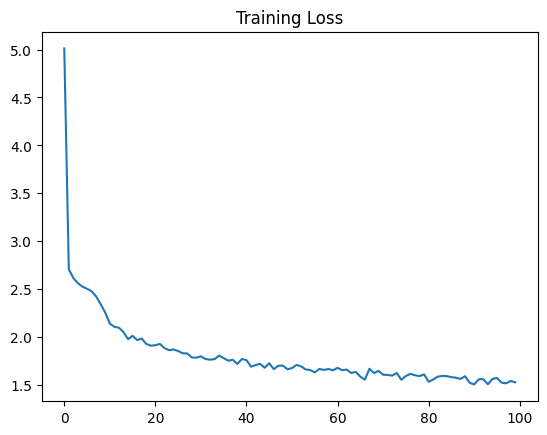

In [392]:
plt.plot(train_loss[::500])
plt.title('Training Loss (per 500 updates)')

Text(0.5, 1.0, 'Validation Loss (per 1k updates)')

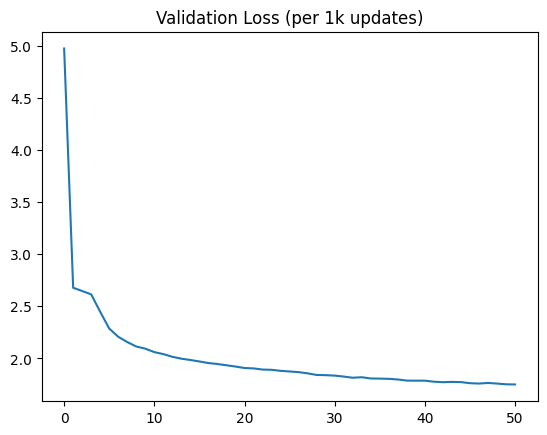

In [393]:
plt.plot(val_loss)
plt.title('Validation Loss (per 1k updates)')

In [402]:
for i in range(3):
  generated = model.generate(torch.ones((16,1),dtype=torch.long,device=HyperParam.device), total=1024)
  generated = tokenizer.decode(generated[0])
  print(generated)
  print("=================================")



SCENER.
Why, made they for shall I cheeks, for love
Because that was the was the esteen.
Seach a past you come cliviness, I how thee the
To anothers the mine bring was sisters her have sake a boy wicks
As freath been hands advolushed it that
Where mine famberst to seems a song hip books
As be which a being starve. We warry argin soft not
and my hussarl. If aught?
Here with the mandar’s snary place:
Bribiatings Do the Dukes virtue sit will be beg we show carces
joy all sit
to up how still go heartends; and sovered. He sabilive
And clean; with that’s such we would on his
Bespected tendons had curer that withoughts victory. The Turked, Tú Cavin!
Fang upon that the throw with the Richoose,
She may Jolus, my service, to the more to the Queenes theon.

BASTARD.
With one, and every tales if John,
And me such Visana Freeur
As be to loved care tune in them themself his
crottest than not picerscens, on to
that Emperor Commen, pray on out actol love!
Hath me, but yourselves at I will make on th